In [1]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
import cv2

# Load the images directories
path = "/Users/san5h0llow/Data_Science/Face_recognition/Data_Set"
image_paths = list(paths.list_images(path))

In [2]:
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)

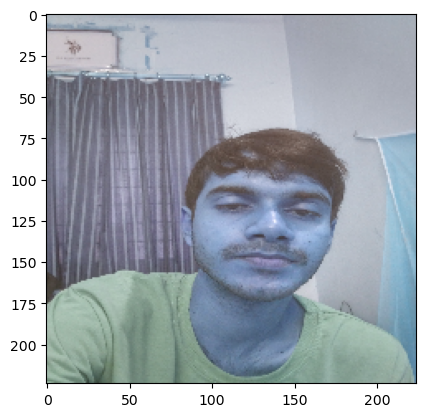

In [3]:
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])

In [4]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np

images = np.array(images) / 255.0
labels = np.array(labels)

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

2024-03-20 06:55:51.168088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from sklearn.model_selection import train_test_split

(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

In [7]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import Xception

base_model = Xception(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input

base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

                                                                                                  
 block4_sepconv2_act (Activ  (None, 28, 28, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 28, 28, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 28, 28, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 14, 14, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 14, 14, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 14, 14, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 14, 14, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 14, 14, 728)          0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 14, 14, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 14, 14, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 14, 14, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 14, 14, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 14, 14, 728)          0         ['block12_sepconv3_bn[0][0]', 
          

In [11]:
batch_size = 40
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 10

In [12]:
history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size), steps_per_epoch= train_steps, validation_data = (test_X, test_Y), validation_steps= validation_steps, epochs= epochs)

/var/folders/29/qgdtjbz504l5y0fqzxvwjwy00000gn/T/ipykernel_17411/504464780.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size), steps_per_epoch= train_steps, validation_data = (test_X, test_Y), validation_steps= validation_steps, epochs= epochs)


Epoch 1/10
72/72 [==============================] - 477s 7s/step - loss: 0.0611 - accuracy: 0.9920 - val_loss: 0.0062 - val_accuracy: 0.9969
Epoch 2/10
72/72 [==============================] - 430s 6s/step - loss: 0.0054 - accuracy: 0.9993 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 3/10
72/72 [==============================] - 434s 6s/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 4/10
72/72 [==============================] - 432s 6s/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 7.7995e-04 - val_accuracy: 1.0000
Epoch 5/10
72/72 [==============================] - 432s 6s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 6.6958e-04 - val_accuracy: 1.0000
Epoch 6/10
72/72 [==============================] - 432s 6s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.8045e-04 - val_accuracy: 1.0000
Epoch 7/10
72/72 [==============================] - 426s 6s/step - loss: 7.0630e-04 - accuracy: 1.0000 - val_loss: 1.5988e-04 - val_accuracy: 

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)

9/9 [==============================] - 43s 5s/step
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       134
    Original       1.00      1.00      1.00       190

    accuracy                           1.00       324
   macro avg       1.00      1.00      1.00       324
weighted avg       1.00      1.00      1.00       324

[[134   0]
 [  0 190]]


In [14]:
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 100.00%


In [15]:
# N = epochs
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

# plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
# plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

# plt.title("Training Loss and Accuracy on Brain Dataset")
# plt.xlabel("Epoch")
# plt.ylabel("Loss / Accuracy")
# plt.legend(loc= "lower left")
# plt.savefig("plot.jpg")

In [16]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [17]:
print(history.history['loss'])
print(history.history['accuracy'])
print(history.history['val_loss'])
print(history.history['val_accuracy'])

[0.061114296317100525, 0.005439016502350569, 0.003646571421995759, 0.0033182038459926844, 0.0014130399795249104, 0.0011690380051732063, 0.0007063001394271851, 0.0007970684091560543, 0.0011701069306582212, 0.0008116992539726198]
[0.9919776916503906, 0.9993023872375488, 0.9993023872375488, 0.9996511936187744, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.006216246634721756, 0.002520663198083639, 0.0028950877021998167, 0.0007799495942890644, 0.0006695773918181658, 0.000280452542938292, 0.00015988227096386254, 0.00014110037591308355, 6.493281398434192e-05, 0.00010337309504393488]
[0.9969135522842407, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


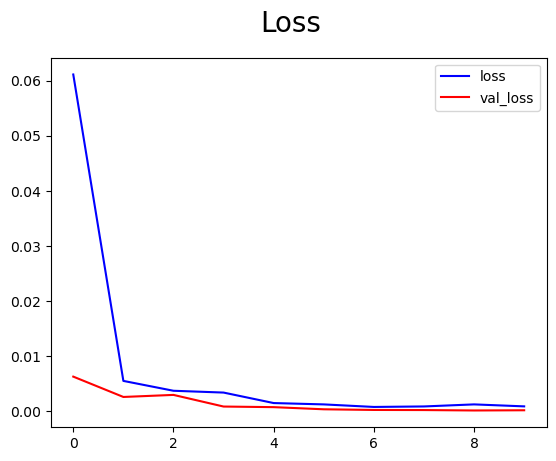

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

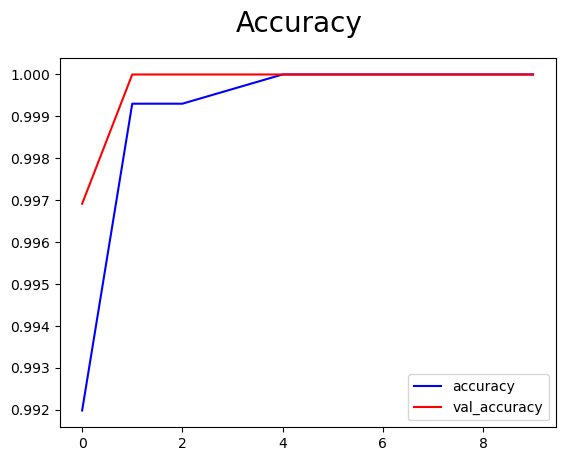

In [19]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()